# Gap junction of Rz cell


__Simulations part__


_Requirements:_ For this exercise you will need Neuron 8, Python 3 and the Python packages Matplotlib
for plotting and Numpy for handling arrays.


We start by importing the relevant packages.

In [1]:
# import Neuron's hoc interpreter
from neuron import h
h.load_file('stdrun.hoc')

# set default units
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
import matplotlib
import plotly
import plotly.tools as tls
from plotly.offline import iplot

Then we define the model neuron.

In [2]:
# initialize by loading my1stnrn.hoc
h.xopen('my_gap.hoc')
h.xopen('my_connection.hoc')
h.load_file('gapjunction.hoc')


1.0

# 1.1 Create two cells
 Define the voltage clamp stimulation.



In [3]:
colors = ['C01','C02']
lables = ['A','B']

In [3]:
# get access to the neuron that was created by my1stnrn.hoc
# it only has a soma
num_cell  =2 
neurons = []
vclamps = []
for i in range(0,num_cell):
    cell = h.rezcell()
    
    # set position of the cell
    # x = (i+1)*1000.
    # y = (i+1)*0.
    # cell.position(x, y, 0)
    # cell.setgid(i)
    neurons.append(cell)

    # neurons[i].nseg = 1
    # neurons[i].diam = 18.8
    # neurons[i].L = 18.8
    # neurons[i].Ra = 123.0
    # neurons[i].g_pas = 2.E-05
    
    vclamps.append(h.VClamp(0.5, sec = cell.soma)) # to maintain the voltage at a certian value


# 1.2 create gap junction

In [4]:
# add gap junction
gj_conductance = 1   #[mS]   ##miao: seems to be uS from website?
# position of gj in axonal sections:
dend_section1 = 0 # it is not used in our case
dend_section2 = 0  # it is not used in our case
section1_pos = 0.9    # position within section1
section2_pos = 0.9  # position within section2
gap = h.dendgapjunction(neurons[0], dend_section1, neurons[1], dend_section1, gj_conductance, section1_pos, section2_pos)

In [4]:
def calculate_cc(v_arrays, stim_start, interested_periods, t_unit = 0.025):
    begin_sim_idx = int(stim_start/t_unit)
    int_period_idx = [int(interested_periods[i]/t_unit) for i in [0,1]]
    delta_v = []
    for i in [0,1]:
        after_v = np.mean(v_arrays[i][int_period_idx[0]:int_period_idx[1]])
        before_v = v_arrays[i][begin_sim_idx]
        this_delta_v = after_v - before_v
        delta_v.append(this_delta_v)
    return delta_v[1]/delta_v[0]


In [7]:
def simulation_rz(neurons, vclamps, gj_conductance = 1, tstop= 200, stim_start = 25, stim_amp = -30, stim_dur = 50,interested_periods = [40,60]):
    
    
    # for gap junction
    dend_section1 = 0 # it is not used in our case
    dend_section2 = 0  # it is not used in our case
    section1_pos = 0.9    # position within section1
    section2_pos = 0.9  # position within section2
    gap = h.dendgapjunction(neurons[0], dend_section1, neurons[1], dend_section1, gj_conductance, section1_pos, section2_pos)
    
    
    # record the current flow through the gap junction
    i_gap = h.Vector()
    v0_gap = h.Vector() # voltage at the gap junction
    v1_gap = h.Vector() 

    # i_gap.record(neurons[0].dend(section1_pos)._ref_i)
    v0_gap.record(neurons[0].dend(section1_pos)._ref_v)
    v1_gap.record(neurons[1].dend(section2_pos)._ref_v)
    
    num_pulses = 1
    inter_stim_interval = 5
    h.tstop = tstop

    stim = h.List()
    for i in range(num_pulses):
        stim.append(h.IClamp(0.5, sec=neurons[0].soma)) # give stimulus at neuron0
        stim[i].amp = stim_amp
        stim[i].delay = stim_start + inter_stim_interval * i
        stim[i].dur = stim_dur
        
        
    ## store other stimuli
    # vectors to store data
    t_vec = h.Vector()                  # Time stamp vector
    t_vec.record(h._ref_t)
    v_cell0 = h.Vector()                 # membrane potential vector for first pyramidal cell
    v_cell1 = h.Vector()                 # membrane potential vector for second pyramidal cell

    # v_pyrA.record(pyrA.soma(0.5)._ref_v)
    # v_pyrB.record(pyrB.soma(0.5)._ref_v)
    v_cell0.record(neurons[0].soma(0.5)._ref_v)
    v_cell1.record(neurons[1].soma(0.5)._ref_v)
    # note that the voltage is recorded in the axon

    # record stimuli
    istim = h.List()
    for i in range(0, num_pulses):
        istim.append(h.Vector())
        istim[i].record(stim[i]._ref_i)
    
    
    
    h.init()
    print('running simulation ...')
    h.run()
    
    
    v0_array = np.array(v0_gap)
    v1_array = np.array(v1_gap)

    v_arrays = [v0_array, v1_array]
    
    
    cc = calculate_cc(v_arrays, stim_start, interested_periods, t_unit= 0.025)
    
    return cc, v_arrays, np.array(istim), np.array(t_vec)
    
    
            


# 2. Add stimulus and record the data
## 2.1 record the voltage at gap junction

In [5]:
# record the current flow through the gap junction
i_gap = h.Vector()
v0_gap = h.Vector() # voltage at the gap junction
v1_gap = h.Vector() 

# i_gap.record(neurons[0].dend(section1_pos)._ref_i)
v0_gap.record(neurons[0].dend(section1_pos)._ref_v)
v1_gap.record(neurons[1].dend(section2_pos)._ref_v)

Vector[2]

## 2.2 iclamp stimulus

In [94]:
num_pulses = 1
inter_stim_interval = 5
h.tstop = 200

stim_start = 25

stim = h.List()
for i in range(num_pulses):
    stim.append(h.IClamp(0.5, sec=neurons[0].soma)) # give stimulus at neuron0
    stim[i].amp = -30
    stim[i].delay = stim_start + inter_stim_interval * i
    stim[i].dur = 50

## 2.3 vclamp stimulus

In [59]:
# # for v_clamp

# # for neuron0
# vclamps[0].amp[0] = -70 #voltage
# vclamps[0].amp[1] = -50
# vclamps[0].amp[2] = -70

# vclamps[0].dur[0] = 10
# vclamps[0].dur[1] = 20
# vclamps[0].dur[2] = 50

# # for neuron1
# vclamps[1].amp[0] = -70 #voltage
# # v_stim[1].amp[1] = -50
# vclamps[1].dur[0] = 50
# # v_stim[1].dur[1] = 20
# # v_stim[i].dur[1] = 10
    
    

In [60]:
# vectors to store data
t_vec = h.Vector()                  # Time stamp vector
t_vec.record(h._ref_t)
v_cell0 = h.Vector()                 # membrane potential vector for first pyramidal cell
v_cell1 = h.Vector()                 # membrane potential vector for second pyramidal cell

# v_pyrA.record(pyrA.soma(0.5)._ref_v)
# v_pyrB.record(pyrB.soma(0.5)._ref_v)
v_cell0.record(neurons[0].soma(0.5)._ref_v)
v_cell1.record(neurons[1].soma(0.5)._ref_v)
# note that the voltage is recorded in the axon

# record stimuli
istim = h.List()
for i in range(0, num_pulses):
    istim.append(h.Vector())
    istim[i].record(stim[i]._ref_i)

# record stimuli
vstim = h.List()
for i in range(0, 2):
    vstim.append(h.Vector())
    vstim[i].record(vclamps[i]._ref_i)

In [61]:
h.init()
print('running simulation ...')
h.run()

running simulation ...


0.0

# plot the results

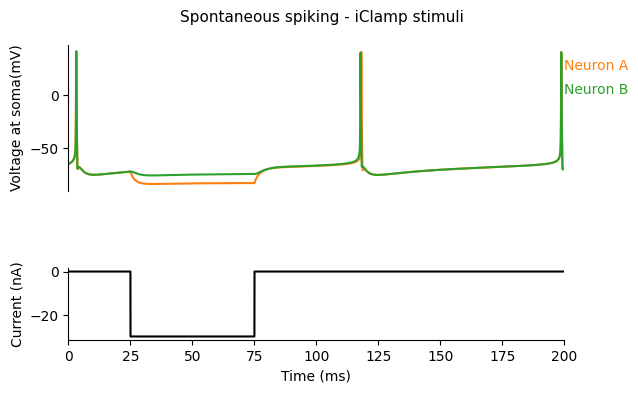

In [62]:
fig = plt.figure()

gs = gridspec.GridSpec(20, 2)

# voltage axis
ax1 = fig.add_subplot(gs[2:10, :])
ax1.plot(t_vec, v_cell0, '-', color='C01')
ax1.plot(t_vec, v_cell1, '-', color='C02')
max_v = max(v_cell0.max(), v_cell1.max())
fig.text(.9, .75, "Neuron A", color='C01')
fig.text(.9, .7, "Neuron B", color='C02')
ax1.set_ylabel('Voltage at soma('+h.units('v')+')')
ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlim([0, h.tstop])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
title = 'Spontaneous spiking - iClamp stimuli'
fig.text(.3, .85,title, fontsize = 11)

# current axis
ax2 = fig.add_subplot(gs[14:18, :], sharex=ax1)
for i in range(num_pulses):
    ax2.plot(t_vec, istim[i], '-', color='k')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Current (nA)')
ax2.set_xlabel('Time ('+h.units('t')+')')
ax2.set_xlim([0, h.tstop])


# # current axis
# ax3 = fig.add_subplot(gs[17:23, :], sharex=ax1)
# ax3.plot(t_vec, v0_gap, '-', color='C01',label ='dendrite A')
# ax3.plot(t_vec, v1_gap, '-', color='C02',label ='dendrite B')
# ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)
# ax3.set_ylabel('voltage at gap junction')
# ax3.set_xlabel('Time ('+h.units('t')+')')
# ax3.set_xlim([0, h.tstop])
# plt.show()
# iplot(tls.mpl_to_plotly(fig))
plt.savefig(f'./results/{title}.png')


# 3. Caculate the R_gap/g_gap

In [63]:
t_array = np.array(t_vec)
t_unit= t_array[1]- t_array[0]
print('unit time: %.3f ms'%t_unit)

unit time: 0.025 ms


In [83]:
beign_idx = int(15/t_unit)
end_idx = int(100/t_unit)

In [84]:
v0_array = np.array(v0_gap)
v1_array = np.array(v1_gap)

v_arrays = [v0_array, v1_array]

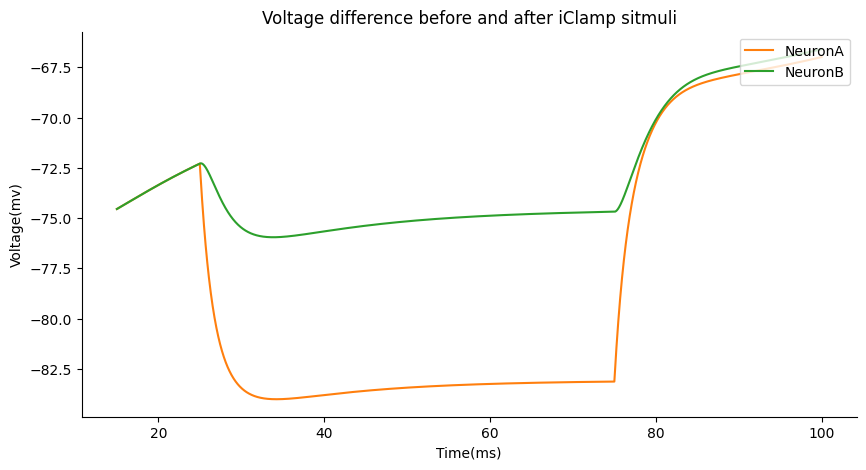

In [103]:
fig, axis = plt.subplots(1,1,figsize = (10,5))
#axis = axis.flatten()
for i in [0,1]:
    axis.plot(t_array[beign_idx:end_idx], v_arrays[i][beign_idx:end_idx],label = 'Neuron%s'%lables[i], color = colors[i])
    axis.set_xlabel('Time(ms)')
    axis.set_ylabel('Voltage(mv)')
axis.legend(loc = 'upper right')
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
title = 'Voltage difference before and after iClamp sitmuli'
plt.title(title)
plt.savefig('results/%s.png'%title)

# # plot the difference between voltage
# axis[1].plot(t_array[beign_idx:end_idx], v_arrays[0][beign_idx:end_idx]-v_arrays[1][beign_idx:end_idx],label = 'V_gap0 - V_gap1')
# axis[1].set_xlabel('time/ms')
# axis[1].set_ylabel('voltage/mv')
# axis[1].legend('leftup')

# # plot the current flow through gap
# axis[2].plot(t_array[beign_idx:end_idx], np.abs(ij_array[beign_idx:end_idx]),label = 'current through gap')
# axis[2].set_xlabel('time/ms')
# axis[2].set_ylabel('current/nv')
# axis[2].legend()

# # for the conductance
# conduc = ij_array[beign_idx:end_idx]/(v_arrays[0][beign_idx:end_idx]-v_arrays[1][beign_idx:end_idx])
# axis[3].plot(t_array[beign_idx:end_idx], np.abs(conduc),label = 'conductance')
# axis[3].set_xlabel('time/ms')
# axis[3].set_ylabel('conductance/mSiemens')
# axis[3].legend()


In [8]:
gap_conds = np.arange(0,10,0.2)
ccs = []
vs = []
for gap_cond in gap_conds:
    num_cell  =2 
    neurons = []
    vclamps = []
    for i in range(0,num_cell):
        cell = h.rezcell()
        neurons.append(cell)
        vclamps.append(h.VClamp(0.5, sec = cell.soma)) 
        
    cc, v,_,_ = simulation_rz(neurons, vclamps, gj_conductance= gap_cond, )
    ccs.append(cc)
    vs.append(v)
    
    

running simulation ...
Changed dt
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...
running simulation ...


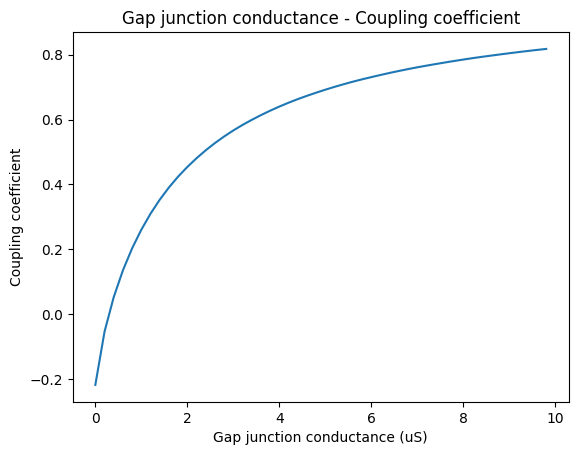

In [15]:
plt.plot(gap_conds, ccs)
plt.xlabel('Gap junction conductance (uS)')
plt.ylabel('Coupling coefficient')
title = 'Gap junction conductance - Coupling coefficient'
plt.title(title)
plt.savefig('results/%s.png'%title)



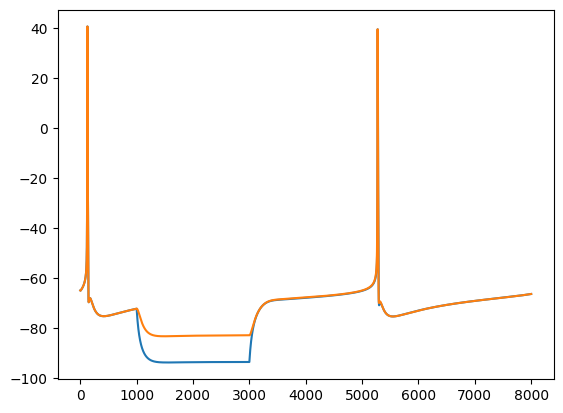

In [115]:
plt.plot(vs[0][0])
plt.plot(vs[0][1])


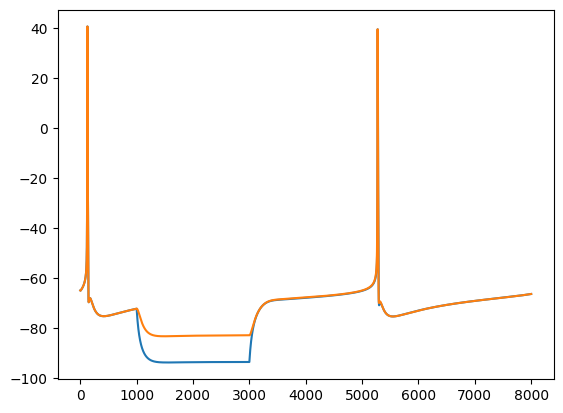

In [116]:
plt.plot(vs[1][0])
plt.plot(vs[1][1])
